# Saliency map

In this task you have a trained classifier and you want to see what parts of the image are the most important ones for the classifier to predict selected class. One of the simplest method to do this is to occlude some parts of the image and see how big is the drop in the class probability compared to the probability for the original image.

We want you to create a heatmap of those occlusions (2D np.array called `heatmap`). Take the original image and replace squares of size 20x20 centered at point (i,j) with a value of your choice. Then pass the image trough the network and calculate the drop in probability class. Do this on a grid with stride 10 ((0,0), (0,10), ..., (10,0), (10,10), ..., (220,220)), so your heatmap is a matrix with 23 rows and 23 columns.

You have to write a code to calculate this heatmap, that runs under 2 minutes.

###### Definitions

In [3]:
from torchvision.models import mobilenet_v2
from PIL import Image
import requests
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt


def get_image():
    url = "http://www.mimuw.edu.pl/~cygan/welonka.jpg"
    im = Image.open(requests.get(url, stream=True).raw)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    size = 224
    transformations = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            normalize,
        ])
    img_tensor = transformations(im.convert("RGB")).unsqueeze(0)
    return img_tensor

def get_model():
    model = mobilenet_v2(pretrained=True)
    model.eval()
    return model

def plot_image(img_tensor):
    img_tensor_c = img_tensor.clone()
    img_tensor_c -= img_tensor_c.min()
    img_tensor_c /= img_tensor_c.max()
    plt.imshow(img_tensor_c[0].permute(1, 2, 0))
    plt.show()

def plot_heatmap(heatmap):
    plt.matshow(heatmap)
    plt.colorbar()
    plt.show()

#Your code

In [4]:
def generate_heatmap(model, img_tensor):
    # YOUR CODE STARTS HERE
    patch_size_x, patch_size_y = (20, 20)
    patch_stride_x, patch_stride_y = (10, 10)
    fill_value = 0.0

    with torch.no_grad():
      orig_img = img_tensor.detach()

      # get initial prediction index and probability
      prediction = model(orig_img)
      prob = torch.nn.functional.softmax(prediction, dim=1).detach().cpu().numpy()

      orig_prediction_index = np.argmax(prob)
      orig_prediction_prob = prediction[0, orig_prediction_index].item()


      output = []
      img_size_y, img_size_x = img_tensor.shape[-2], img_tensor.shape[-1]
      for y in range(0, img_size_y, patch_stride_y):
        output_row = []
        for x in range(0, img_size_x, patch_stride_x):
            occluded_img = orig_img.clone()
            occluded_img[:, :, y-patch_size_y//2 : y+patch_size_y//2, x-patch_size_x//2 : x+patch_size_x//2] = fill_value

            occluded_prediction = model(occluded_img)
            occluded_prob = torch.nn.functional.softmax(occluded_prediction, dim=1).detach().cpu()[0, orig_prediction_index]
            prob_drop = (orig_prediction_prob - occluded_prob)

            output_row.append(prob_drop)
        output.append(output_row)

    heatmap = np.array(output)
    # YOUR CODE ENDS HERE
    return heatmap


#Test

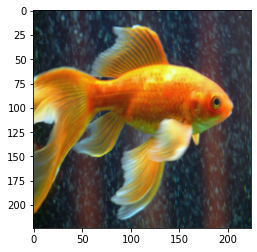

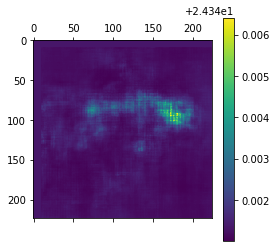

In [5]:
img_tensor = get_image()
model = get_model()
heatmap = generate_heatmap(model, img_tensor)

plot_image(img_tensor)
plot_heatmap(heatmap)